In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

### Задача регрессии. В качесте метрики использую RMSE

In [115]:
df = pd.read_csv("train.csv", index_col="Id")

In [116]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Смотрю сколько в процентном соотношении в данных nan. Признаки, в которых много nan (>40%) удаляю.

In [117]:
(df.isna().sum() / len(df)).sort_values(ascending=False).head(8)

PoolQC         0.995205
MiscFeature    0.963014
Alley          0.937671
Fence          0.807534
MasVnrType     0.597260
FireplaceQu    0.472603
LotFrontage    0.177397
GarageYrBlt    0.055479
dtype: float64

In [118]:
nan_df = pd.DataFrame({"percent": df.isna().sum() / len(df)})
df = df.drop(nan_df[nan_df["percent"] > 0.4].index, axis=1)

In [119]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [120]:
df.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

### Если какой-то признак состоит на более чем 95% из одного значения, то такой признак я удаляю

In [121]:
for column in df.columns:
    if df.groupby([column]).size().max() / len(df) > 0.95:
        df = df.drop(column, axis=1)
df.shape

(1460, 64)

In [122]:
categorical_columns = df.select_dtypes(include=['object']).columns
len(categorical_columns)

32

### Смотрю категориальные признаки, у которых 4 или меньше различных значений. Для таких признаков я прочитал информацию о том что они значат и выяслнил, что значения в ниx обозначают есть ли что-то в доме или говорят о каком-то качестве объекта(хороший, плохой и т.д.). В таком случае их можно переделать в численные следующим способом: "плохой" = 0, "хороший" = 1 и т.п. 

In [123]:
categorical_nunique_df = pd.DataFrame({"unique": df[categorical_columns].nunique()})
df[categorical_nunique_df[categorical_nunique_df["unique"] <= 4].index].columns

Index(['LotShape', 'LandContour', 'LandSlope', 'ExterQual', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'CentralAir', 'KitchenQual', 'GarageFinish',
       'PavedDrive'],
      dtype='object')

In [124]:
def remake_column(value_cat, value_num, column_name):
    df[column_name] = df[column_name].fillna(0)
    for i in range(len(value_cat)):
        df.loc[df[column_name] == value_cat[i], column_name] = value_num[i]
    df[column_name] = df[column_name].astype(int)

In [125]:
df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'LotShape',
       'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', 'CentralAir',
       'Electrical', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
       'ScreenPorch', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition',
       'SalePrice'],
      dty

In [126]:
remake_column(["IR3", "IR2", "IR1", "Reg"], [1, 2, 3, 4], "LotShape")
remake_column(["Po", "Fa", "TA", "Gd", "Ex"], [-2, -1, 0, 1, 2], "ExterQual")
remake_column(["NA", "Po", "Fa", "TA", "Gd", "Ex"], [0, 1, 2, 3, 4, 5], "BsmtQual")
remake_column(["NA", "No", "Mn", "Av", "Gd"], [0, 1, 2, 3, 4], "BsmtExposure")
remake_column(["Po", "Fa", "TA", "Gd", "Ex"], [0, 1, 2, 3, 4], "KitchenQual")
remake_column(["NA", "Unf", "RFn", "Fin"], [0, 1, 2, 3], "GarageFinish")

In [127]:
categorical_columns = df.select_dtypes(include=['object']).columns
len(categorical_columns)

26

### Все nan заменяю на 0. Оставшиеся категориальные признаки кодирую с помощью OneHot

In [129]:
df = df.fillna(0)

In [130]:
df.shape

(1460, 64)

In [131]:
df = pd.get_dummies(df, dtype=int)
df.shape

(1460, 226)

In [132]:
y = df["SalePrice"]
df = df.drop("SalePrice", axis=1)

### Можно заметить, что цена домов не похожа на нормальное распределение. Лучше это изменить, логарифмировав значения

<Axes: >

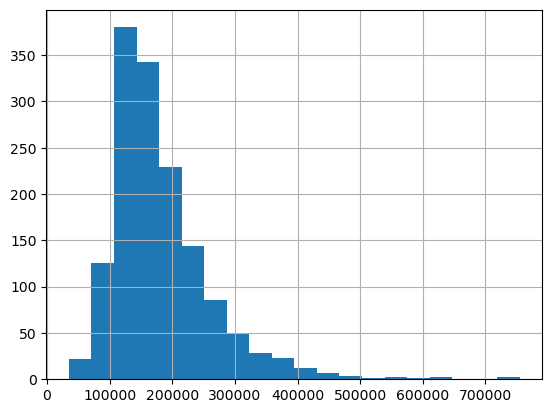

In [133]:
y.hist(bins=20)

<Axes: >

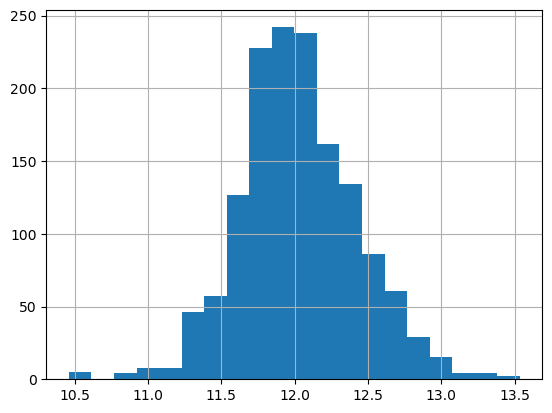

In [134]:
np.log(1 + y).hist(bins=20)

### Всю работу с данными для удобства внёс в один класс. Далее займусь подбором лучшей модели

In [135]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np
import sklearn

def remake_column(df_local, value_cat, value_num, column_name):
    df_local.loc[:, column_name] = df_local[column_name].fillna(0)
    for i in range(len(value_cat)):
        df_local.loc[df_local[column_name] == value_cat[i], column_name] = value_num[i]
    df_local.loc[:, column_name] = df_local[column_name].astype(int)
    return df_local[column_name]
    
class BaseDataPreprocessor(sklearn.base.TransformerMixin):
    def __init__(self, need_column):
        self.need_column = need_column
        self.ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        pass

    def fit(self, data, *args):
        return self
        
    def transform(self, df, train=False) -> np.array:
        df = df[self.need_column]
        
        df.loc[:,"LotShape"] = remake_column(df, ["IR3", "IR2", "IR1", "Reg"], [1, 2, 3, 4], "LotShape")
        df.loc[:,"ExterQual"] = remake_column(df, ["Po", "Fa", "TA", "Gd", "Ex"], [0, 1, 2, 3, 4], "ExterQual")
        df.loc[:,"BsmtQual"] = remake_column(df, ["NA", "Po", "Fa", "TA", "Gd", "Ex"], [0, 1, 2, 3, 4, 5], "BsmtQual")
        df.loc[:,"BsmtExposure"] = remake_column(df, ["NA", "No", "Mn", "Av", "Gd"], [0, 1, 2, 3, 4], "BsmtExposure")
        df.loc[:,"KitchenQual"] = remake_column(df, ["Po", "Fa", "TA", "Gd", "Ex"], [0, 1, 2, 3, 4], "KitchenQual")
        df.loc[:,"GarageFinish"] = remake_column(df, ["NA", "Unf", "RFn", "Fin"], [0, 1, 2, 3], "GarageFinish")

        categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
        if train:
            one_hot_encoded = self.ohe.fit_transform(df[categorical_columns])
        else:
            one_hot_encoded = self.ohe.transform(df[categorical_columns])
        
        one_hot_df = pd.DataFrame(one_hot_encoded, columns=self.ohe.get_feature_names_out(categorical_columns))

        one_hot_df.index = np.linspace(df.index.min(), df.index.max(), len(df))
        
        df = pd.concat([df, one_hot_df], axis=1, join="inner")
        df = df.drop(categorical_columns, axis=1)
        
        df = df.fillna(0)
        
        df = np.log(1 + df)
        return df

In [136]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

In [137]:
preprocessor = BaseDataPreprocessor(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'LotShape',
       'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', 'CentralAir',
       'Electrical', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
       'ScreenPorch', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition'])

scaler = StandardScaler()

df_train = pd.read_csv("train.csv", index_col="Id")
df_test = pd.read_csv("test.csv", index_col="Id")

y_train = df_train["SalePrice"]
X_train = preprocessor.transform(df_train.drop("SalePrice", axis=1), train=True)
X_test = preprocessor.transform(df_test)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [138]:
parameters = {"alpha":np.logspace(-4, 5, 10)}
model = Ridge()
grid = GridSearchCV(model, parameters, cv=10)
answer = grid.fit(X_train, y_train)
params = answer.best_params_
print(params, answer.best_score_)

model = Ridge(**params)
cross_val_score(model, X_train, y_train, cv=10).mean()

{'alpha': 100.0} 0.8469185378072893


0.8469185378072893

In [139]:
from sklearn.tree import DecisionTreeRegressor

parameters = {"criterion":["squared_error"],
              "max_depth":[3, 4, 5],
              "min_samples_split":[3, 4],
              "min_samples_leaf":[2, 3, 4]}
model = DecisionTreeRegressor()
grid = GridSearchCV(model, parameters, cv=5)
answer = grid.fit(X_train, y_train)
params = answer.best_params_
print(params, answer.best_score_)

model = DecisionTreeRegressor(**params)
cross_val_score(model, X_train, y_train, cv=10).mean()

{'criterion': 'squared_error', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 3} 0.7436829741564501


0.7373361772694584

In [ ]:
from sklearn.ensemble import RandomForestRegressor

parameters = {"n_estimators":[2000],
              "criterion":["squared_error"],
              "max_depth":[6],
              "min_samples_split":[3, 4],
              "min_samples_leaf":[2, 3]}

model = RandomForestRegressor()
grid = GridSearchCV(model, parameters, cv=5)
answer = grid.fit(X_train, y_train)
params = answer.best_params_
print(params)

model = RandomForestRegressor(**params)
cross_val_score(model, X_train, y_train, cv=10).mean()

{'criterion': 'squared_error', 'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 2000}


In [ ]:
from catboost import CatBoostRegressor

parameters = {"loss_function":["RMSE"],
              "iterations":[7000],
              "learning_rate":[0.01, 0.1],
              "depth":[3, 5, 7],
              "l2_leaf_reg":[0.1, 1]}
model = CatBoostRegressor(verbose=False)
grid = GridSearchCV(model, parameters, cv=5)
answer = grid.fit(X_train, y_train)
params = answer.best_params_
print(params)

model = CatBoostRegressor(**params, verbose=False)
cross_val_score(model, X_train, y_train, cv=10).mean()

### CatBoost показал лучшие результаты. Воспользуюсь им

In [112]:
model.fit(X_train, y_train)
pred = model.predict(X_test)

In [113]:
answer = df_test.copy()
answer["SalePrice"] = pred
answer = answer["SalePrice"]
answer.to_csv("answer.csv")